In [1]:
library(swanR)
library(stringr)
library(purrr)
library(magrittr)
library(data.table)
library(lubridate)
library(ggplot2)
library(openxlsx)
library(xts)
library(zoo)
library(microbenchmark)
library(rethinking)
data(Howell1)
d <- Howell1 %>% as.data.table
d2 <- d[18 <= age]

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')
although this causes Stan to throw an error on a few processors.


Attaching package: 'rstan'


The following object is masked from 'package:magrittr':

    extract


Loading required package: parallel

Loading required package: dagitty

rethinking (Version 2.00)


Attaching package: 'rethinking'


The following object is masked from 'package:purrr':

    map


The following object is masked from 'package:stats':

    rstudent




# Easy
## 4E1
In the model definition below, which line is the likelihood?

\begin{align}
y_i & \sim \mathit{Normal}(\mu; \sigma) \\
\mu & \sim \mathit{Normal}(0, 10) \\
\sigma & \sim \mathit{Uniform}(0, 10) \\
\end{align}

The $y_i$ line

## 4E2
In the model definition just above, how many parameters are in the posterior distribution?

Two, mu and sigma.

## 4E3
Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors.

$Pr(y|\mu,\sigma) \sim \frac{Normal(y|\mu,\sigma) Normal(\mu|0,10) Uniform(\sigma | 0,10)}{\int Normal(y|\mu,\sigma) Normal(\mu|0,10) Uniform(\sigma | 0,10) dy}$

## 4E4
In the model definition below, which line is the linear model?
\begin{align}
y_i & \sim \mathit{Normal}(\mu, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \mathit{Normal}(0,10) \\
\beta & \sim \mathit{Normal}(0,1) \\
\sigma & \sim \mathit{Uniform}(0, 10) \\
\end{align}

The second, $\mu$ line

## 4E5
In the model definition just above, how many parameters are in the posterior distribution?

Three: $\mu$, $\beta$, and $\sigma$

# Medium

## 4M1
For the model definition below, simulate observed heights from the prior (not the posterior).

\begin{align}
y_i & \sim \mathit{Normal}(\mu,\sigma) \\
\mu & \sim \mathit{Normal}(0,10) \\
\sigma & \sim \mathit{Uniform}(0,10) \\
\end{align}

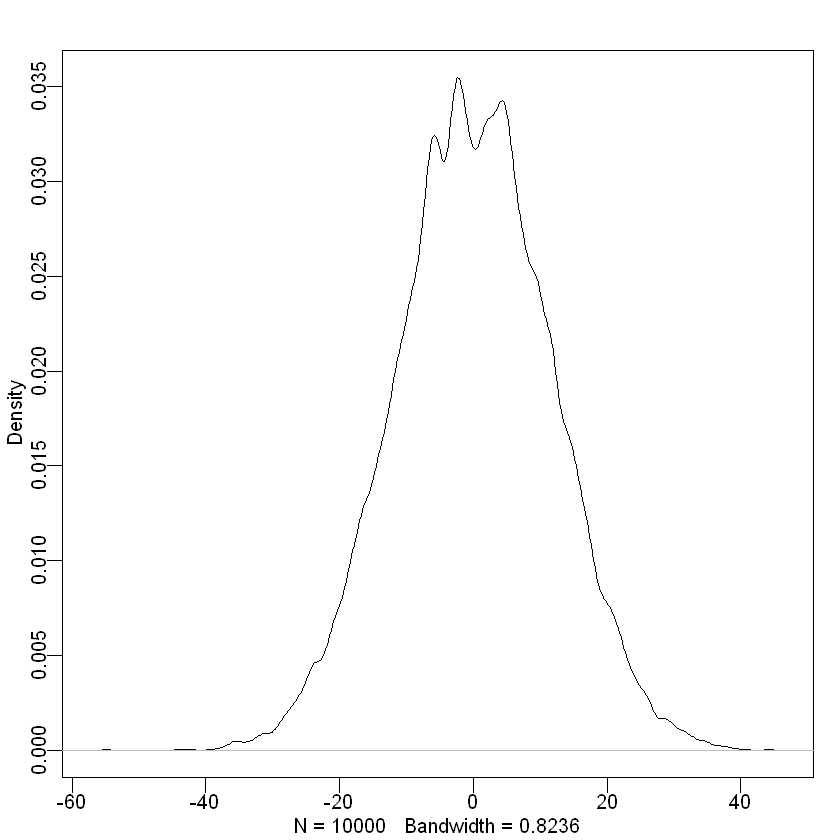

In [2]:
n <- 1e4
prior_samples <- rnorm(n, rnorm(n, 0, 10), runif(n,0,10))
dens(prior_samples)

## 4M2
Translate the model just above into a map formula

In [3]:
m4m2 <- 
  alist(
    height ~ dnorm(mu, sigma),
    mu ~ dnorm(0, 10),
    sigma ~ dunif(0, 10)
  ) %>% 
  map(d2)

## 4M3

Translate the map model formula below into a mathematical model definition.
```{r}
flist <- alist(
    y ~ dnorm( mu , sigma ),
    mu <- a + b*x,
    a ~ dnorm( 0 , 50 ),
    b ~ dunif( 0 , 10 ),
    sigma ~ dunif( 0 , 50 )
)
```

\begin{align}
y_i & \sim \mathit{Normal}(\mu_i,\sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \mathit{Normal}(0,50) \\ 
\beta & \sim \mathit{Uniform}(0,10) \\
\sigma & \sim \mathit{Uniform}(0,50)
\end{align}

## 4M4
A sample of students is measured for height each year for 3 years. After the third year, you want
to fit a linear regression predicting height using year as a predictor. Write down the mathematical
model definition for this regression, using any variable names and priors you choose. Be prepared to
defend your choice of priors.

\begin{align}
h_i & \sim \mathit{Normal}(\mu_i,\sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \mathit{Normal}(165,100) \\
\beta & \sim \mathit{Normal}(0,10) \\
\sigma & \sim \mathit{Uniform}(0,50) \\
\end{align}

## 4M5
Now suppose I tell you that the average height in the first year was 120 cm and that every
student got taller each year. Does this information lead you to change your choice of priors? How?

\begin{align}
\alpha & \sim \mathit{Normal}(135,30) \\
\beta & \sim \mathit{Normal}(8,20) \\
\end{align}

## 4M6
Now suppose I tell you that the variance among heights for students of the same age is never
more than 64cm. How does this lead you to revise your priors?

\begin{align}
\sigma & \sim \mathit{Uniform}(0,64) \\
\end{align}

# Hard

## 4H1
The weights listed below were recorded in the !Kung census, but heights were not recorded for
these individuals. Provide predicted heights and 89% intervals (either HPDI or PI) for each of these
individuals. That is, fill in the table below, using model-based predictions.

| Individual | weight | expected height | 89% interval |
| :--- | :--- | :--- | :--- |
| 1 | 46.95 |  | |
| 2 | 43.72 |  | |
| 3 | 64.78 |  | |
| 4 | 32.59 |  | |
| 5 | 54.63 |  | |


In [4]:
m4h1 <-
  alist(
    height ~ dnorm(mu,sigma),
    mu <- a + b * weight,
    a ~ dnorm(156,100),
    b ~ dnorm(0,10),
    sigma ~ dunif(0,50)
  ) %>% 
  map(d2)

missingPeople <- 
  data.table( individual = 1:5,
              weight = c(46.95, 43.72, 64.78, 32.59, 54.63))

mu <- link(m4h1, missingPeople, 1e4)

missingPeople[ , `expected height` := apply( mu , 2 , mean )]
missingPeople[ , `89% interval` := 
                      apply( mu , 2 , HPDI , prob=0.89 ) %>% 
                      apply(2, round, digits = 2) %>% 
                      apply(2, str_c, collapse = " - ")]

missingPeople

individual,weight,expected height,89% interval
<int>,<dbl>,<dbl>,<chr>
1,46.95,156.3714,155.92 - 156.84
2,43.72,153.4481,153.02 - 153.89
3,64.78,172.5088,171.13 - 173.91
4,32.59,143.3747,142.48 - 144.33
5,54.63,163.3223,162.55 - 164.1


## 4H2
Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right,
you should end up with a new data frame with 192 rows in it. 

1. Fit a linear regression to these data, using map. Present and interpret the estimates. For every
10 units of increase in weight, how much taller does the model predict a child gets?

In [5]:
d3 <- d[age < 18]
m4h2 <-
  alist(
    height ~ dnorm(mu,sigma),
    mu <- a + b * weight,
    a ~ dnorm(108,100),
    b ~ dnorm(0,10),
    sigma ~ dunif(0,50)
  ) %>% 
  map(d3)
precis(m4h2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,58.242518,1.39698726,56.009863,60.475174
b,2.719533,0.06828268,2.610404,2.828662
sigma,8.436760,0.43051043,7.748721,9.124799


This model predicts that for every 10 kg (22 lbs) a child gains, their expected height increases by 27 cm (10 inches)

2. Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose
the MAP regression line and 89% HPDI for the mean. Also superimpose the 89% HPDI for
predicted heights.

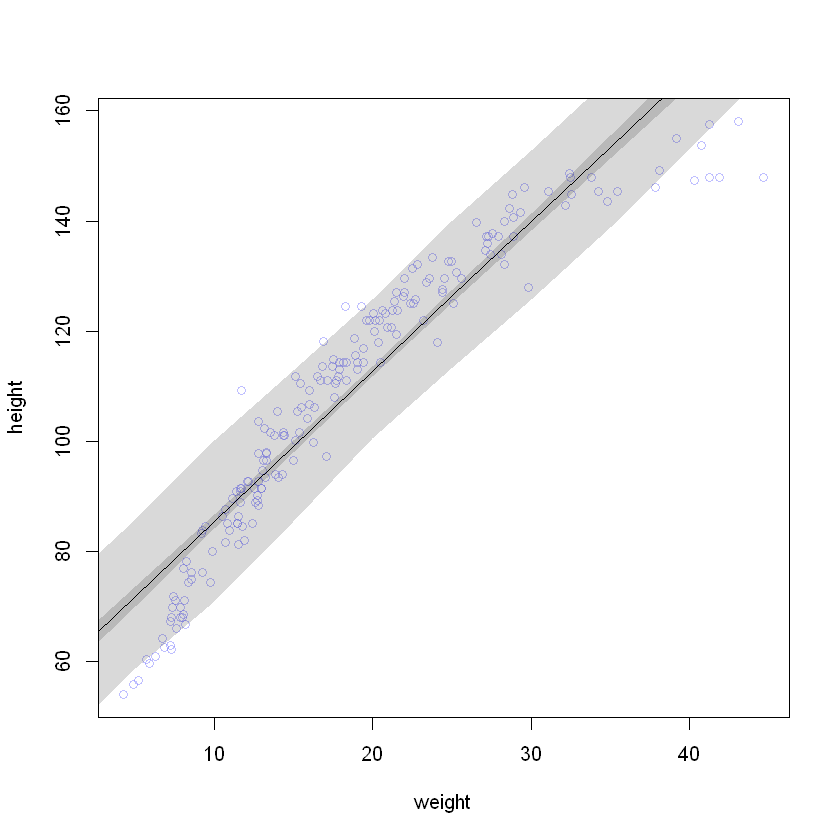

In [6]:
# build a sequence of weights to simulate
weightSeq <- seq(0,45,5)

# build the expected heights for our weights
mu <- link(m4h2, data.frame(weight = weightSeq), 1e4)
muMean <- apply(mu,2,mean)
muHPDI <- apply(mu,2,HPDI)

# build the height predictions for our weights 
simHeight <- sim(m4h2, list(weight = weightSeq))
heightPI <- apply(simHeight, 2, PI, prob = 0.89)

# plot the heights of the children
plot(height ~ weight, d3, col = col.alpha(rangi2, 0.5))
# add the expected means
lines( weightSeq , muMean )
# plot a shaded region for 89% HPDI
shade( muHPDI , weightSeq )
# draw PI region for simulated heights
shade( heightPI , weightSeq )

3. What aspects of the model fit concern you? Describe the kinds of assumptions you would
change, if any, to improve the model. You don’t have to write any new code. Just explain what the
model appears to be doing a bad job of, and what you hypothesize would be a better model.

The data has a steep increase at the beginning and a becomes more gradual at the end. This curvature isn't modelled in our linear model and indeed, many data points fall outside our prediction distribution. A model that accounts for this curvature or puberty/infant status would perhaps improve things.

## 4H3 
Suppose a colleague of yours, who works on allometry, glances at the practice problems just
above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body
weight that scales with height!” Let’s take your colleague’s advice and see what happens.

1. Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use
the entire Howell1 data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic
approximation:

\begin{align}
h_i & \sim \mathit{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta \log (w_i) \\
\alpha & \sim \mathit{Normal}(178,100) \\
\beta & \sim \mathit{Normal}(0,100) \\
\sigma & \sim \mathit{Uniform}(0,50)\\
\end{align}

where $h_i$ is the height of individual $i$ and $w_i$ is the weight (in kg) of individual $i$. The function for
computing a natural log in R is just log. Can you interpret the resulting estimates?

In [7]:
m4h3 <-
  alist(
    height ~ dnorm(mu,sigma),
    mu <- a + b * log(weight),
    a ~ dnorm(178,100),
    b ~ dnorm(0,100),
    sigma ~ dunif(0,50)
  ) %>% 
  map(d)
m4h3


Quadratic approximate posterior distribution

Formula:
height ~ dnorm(mu, sigma)
mu <- a + b * log(weight)
a ~ dnorm(178, 100)
b ~ dnorm(0, 100)
sigma ~ dunif(0, 50)

Posterior means:
         a          b      sigma 
-23.784242  47.075309   5.134695 

Log-likelihood: -1661.9 

On average, these peoples' heights are expected to increase by 47cm (18.5in) every time their body weight near triples (x2.7)

2. Begin with this plot:
```{R}
plot( height ~ weight , data=Howell1, col=col.alpha(rangi2,0.4) )
```
Then use samples from the quadratic approximate posterior of the model in (1) above to superimpose on the plot: 

  1. the predicted mean height as a function of weight
  2. the 97% HPDI for the mean, and
  3. the 97% HPDI for predicted heights.

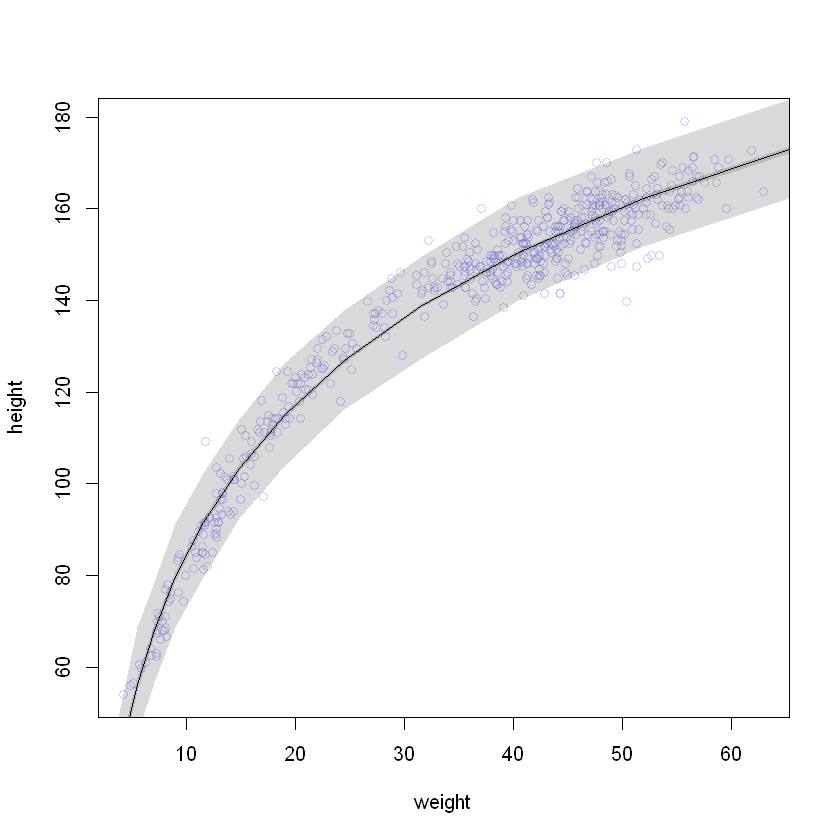

In [8]:
# build a sequence of weights to simulate
weightSeq <- exp(seq(1.2,4.2,0.25))

# build the expected heights for our weights
mu <- link(m4h3, data.frame(weight = weightSeq), 1e4)
muMean <- apply(mu,2,mean)
muHPDI <- apply(mu,2,HPDI, prob = 0.97)

# build the height predictions for our weights 
simHeight <- sim(m4h3, list(weight = weightSeq))
heightPI <- apply(simHeight, 2, PI, prob = 0.97)

# plot the population's heights
plot( height ~ weight , data=Howell1, col=col.alpha(rangi2,0.4) )
# add the expected heights for each weight
lines( weightSeq , muMean )
# plot a shaded region for 89% HPDI
shade( muHPDI , weightSeq )
# draw PI region for simulated heights
shade( heightPI , weightSeq )